# Before/After standardization

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # stop showing tensorflow logs

from datasets import load_dataset
import tensorflow as tf
import numpy as np

# Adding decorator to be able to serialize the function for saving the model
@tf.keras.utils.register_keras_serializable("Custom", name="text_standardization")
def standardize(text):
    "Text standardization function. Tries to make things uniform."
    text = tf.strings.lower(text) # Lowercase everything
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '') # Keep space, a to z and punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') # Add spaces around punctuation.
    text = tf.strings.strip(text) # Strip whitespace.

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ') # Add start and end token
    return text

In [2]:
standardize("What is AI?")

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] what is ai ? [END]'>

In [16]:
import json
save_dir = "./models/transformer_v7"

with open(f"{save_dir}/loss.json", "r") as f:
    data = json.load(f)

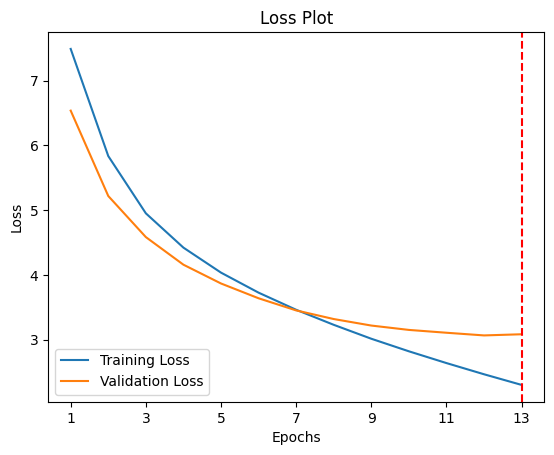

In [21]:
plt.plot(range(1, len(data['loss']) + 1), data['loss'], label='Training Loss')
plt.plot(range(1, len(data['loss']) + 1), data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')

# Set the x-axis ticks
plt.xticks(range(1, len(data['loss']) + 1, 2))

# Draw a vertical line at x=12
plt.axvline(x=13, color='red', linestyle='--')

plt.legend()
plt.show()

In [123]:
"""
This script creates a tensorflow dataset for the brockport-gpt-4-qa dataset to feed into the model.

This also does some preprocessing of the data, such as adding start and end tokens, and standardizing the text.
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # stop showing tensorflow logs

from datasets import load_dataset
import tensorflow as tf
import numpy as np

batch_size=10
max_vocab_size=5000

# # Adding decorator to be able to serialize the function for saving the model
# @tf.keras.utils.register_keras_serializable("Custom", name="text_standardization")
# def standardize(text):
#     "Text standardization function. Tries to make things uniform."
#     text = tf.strings.lower(text) # Lowercase everything
#     text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '') # Keep space, a to z and punctuation.
#     text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') # Add spaces around punctuation.
#     text = tf.strings.strip(text) # Strip whitespace.

#     text = tf.strings.join(['[START]', text, '[END]'], separator=' ') # Add start and end token
#     return text


context_raw = ["What is AI?", "AI stands for Artificial Intelligence."]
target_raw = ["AI stands for Artificial Intelligence.", "hi"]

is_train_mask = np.random.uniform(size=(len(target_raw),)) < 2

train_context = np.array(context_raw)[is_train_mask]
train_target = np.array(target_raw)[is_train_mask]

val_context = np.array(context_raw)[~is_train_mask]
val_target = np.array(target_raw)[~is_train_mask]

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_context, train_target))
    .shuffle(len(context_raw))
    .batch(batch_size)
)
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((val_context, val_target))
    .shuffle(len(context_raw))
    .batch(batch_size)
)

text_processor = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_vocab_size,
    ragged=True
)

text_processor.adapt(train_raw.map(lambda context, target: context))
#text_processor.adapt(train_raw.map(lambda context, target: target))

def process_text(context, target):
    context = text_processor(context).to_tensor()
    target  = text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [124]:
map_dict = {k: v for k, v in enumerate(text_processor.get_vocabulary())}
map_dict

{0: '',
 1: '[UNK]',
 2: 'ai',
 3: '[START]',
 4: '[END]',
 5: 'what',
 6: 'stands',
 7: 'is',
 8: 'intelligence',
 9: 'for',
 10: 'artificial',
 11: '?',
 12: '.'}

In [125]:
for i in train_ds.take(1):
    data = i

In [126]:
print([map_dict[idx] for idx in data[0][0].numpy()[0]])
print([map_dict[idx] for idx in data[0][1].numpy()[0]])
print([map_dict[idx] for idx in data[1].numpy()[0]])

['[START]', 'what', 'is', 'ai', '?', '[END]', '', '']
['[START]', 'ai', 'stands', 'for', 'artificial', 'intelligence', '.']
['ai', 'stands', 'for', 'artificial', 'intelligence', '.', '[END]']


In [127]:
print(data[0][0].numpy()[0])
print(data[0][1].numpy()[0])
print(data[1].numpy()[0])


[ 3  5  7  2 11  4  0  0]
[ 3  2  6  9 10  8 12]
[ 2  6  9 10  8 12  4]


In [79]:
for i in train_raw.take(1):
    d2=i

In [80]:
print(d2[0])
print(d2[1])

tf.Tensor([b'What is AI?'], shape=(1,), dtype=string)
tf.Tensor([b'AI stands for Artificial Intelligence.'], shape=(1,), dtype=string)


# Key

data[0][0] context<br>
data[0][1] target_in<br>
data[1] target_out

In [59]:
data[0][0]

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[7, 1, 1, 6, 1, 8]])>

['[START]', '[UNK]', '[UNK]', 'ai', '[UNK]', '[END]']

In [10]:
import pandas as pd

In [11]:
dataset = load_dataset("msaad02/categorized-data", split="train")
category_df = dataset.to_pandas()

qa_df = pd.concat([
    load_dataset("msaad02/brockport-gpt-4-qa", split="train").to_pandas()
])

df = pd.merge(qa_df, category_df[["url", "category", "subcategory"]], on="url", how="left")

In [25]:
filtered_df = df.loc[df['subcategory'] == 'apply']
filtered_df.loc[:,['question', 'answer']].to_csv("TMP.csv",index=False)


In [31]:
filtered_df = df.loc[df['question'].str.contains('SAT|required')]
filtered_df.to_csv("TMP.csv",index=False)

In [4]:
val_ds

<_ParallelMapDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>